In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [9]:
d = pd.read_csv('../tables/merged_observed.csv')

In [10]:
d = d[np.logical_not((d['Ice_Flag_2DS']==1) | (d['ED-liquid_2DS']>=60E-6) | (d['LWC_FCDP']>0.005) | (d['ams_tot'] < 0.04) | (d['N_CCN_stdPT'] < 50))].reset_index(drop=True)
d['non_org_tot'] = d['SO4_Ave_IsoK_STP']+ d['NO3_Ave_IsoK_STP'] + d['NH4_Ave_IsoK_STP'] + d['Chl_Ave_IsoK_STP']
d = d[d['non_org_tot']>0]
#d = d[((d['CO_ppm']>0.075)) & (d['CO_ppm']<.1)]
#d = d[((d['CO_ppm']>0.175)) & (d['CO_ppm']<.2)]
#d = d[(d['Org_Ave_IsoK_STP']>=0) & (d['SO4_Ave_IsoK_STP']>=0) & (d['NO3_Ave_IsoK_STP']>=0) & (d['NH4_Ave_IsoK_STP']>=0) & (d['Chl_Ave_IsoK_STP']>=0)].reset_index(drop=True)

In [11]:
def calc_k(data, org_k, so4_k):
    d = data.copy()
    d['k'] = np.nan
    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['non_org_vc'] = d['non_org_tot'] / 1770
    #d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    #d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    #d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['non_org_vc']#+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['non_org_vc']/d['ams_tot_vc']# + no3_k*d['NO3_vc']/d['ams_tot_vc'] + nh4_k*d['NH4_vc']/d['ams_tot_vc'] + chl_k*d['Chl_vc']/d['ams_tot_vc']

    return d

In [12]:
# Define an objective function to minimize
def objective(params, d):
    org_k, so4_k = params
    k_predicted = calc_k(d, org_k, so4_k)['k']
    # Calculate the sum of squared differences
    return np.sum((d['k_obs'] - k_predicted)**2)

# Define initial guesses for the kappas
initial_guess = [0.1, 0.1]

d_sub = d#[(d['k_obs']>0.0)&(d['k_obs']<.1)]

# Perform the optimization
result = minimize(objective, initial_guess, args=(d_sub), method='Nelder-Mead')

# Extract the optimized kappa values
org_k_opt, so4_k_opt = result.x

print("Optimized kappa values:")
print("org_k:", org_k_opt)
print("so4_k:", so4_k_opt)

Optimized kappa values:
org_k: 0.3830076294997694
so4_k: 0.38834737965371324


In [13]:
result.x

array([0.38300763, 0.38834738])

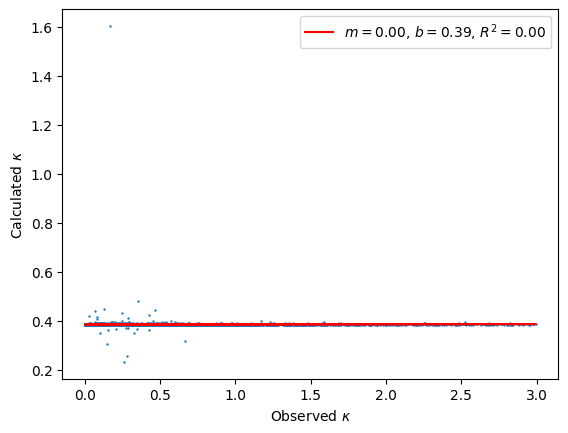

In [14]:
d_sub = calc_k(d_sub, *result.x).dropna(subset=['k_obs', 'k'])
# Fit a line to the data
slope, intercept, r_value, _, _ = linregress(d_sub['k_obs'], d_sub['k'])
r_squared = r_value ** 2

# Plot the scatter and fitted line
plt.scatter(d_sub['k_obs'], d_sub['k'], s=0.5)
plt.plot(d_sub['k_obs'], slope * d_sub['k_obs'] + intercept, color="red", label=f"$m = {slope:.2f}$, $b = {intercept:.2f}$, $R^2 = {r_squared:.2f}$")
#plt.xlim([0, 0.2])
#plt.ylim([0, 0.2])
plt.xlabel(r"Observed $\kappa$")
plt.ylabel(r"Calculated $\kappa$")
plt.legend()
plt.savefig('../figures/ams_fit.png', dpi=300)